[[-1.0856306   0.99734545  0.2829785  ..., -0.90932702  0.47026375
  -1.11143045]
 [-0.74882747  0.56759473  0.71815054 ..., -0.35929672 -1.60969508
   0.01357006]
 [-1.77422355 -1.20137731  1.09625679 ...,  2.04043199  1.01591697
  -1.63378817]
 [-0.45059869  0.60959032  1.17374438 ..., -0.1227329   1.79448602
  -0.32050951]]
[[-1.0856306   0.99734545  0.2829785  ..., -0.90932702  0.47026375
  -1.11143045]
 [-0.74882747  0.56759473  0.71815054 ..., -0.35929672 -1.60969508
   0.01357006]
 [-1.77422355 -1.20137731  1.09625679 ...,  2.04043199  1.01591697
  -1.63378817]
 [-0.45059869  0.60959032  1.17374438 ..., -0.1227329   1.79448602
  -0.32050951]]
[[  2.77880107e-09]
 [  3.20322848e-06]
 [  1.54301198e-06]
 [  9.99995251e-01]]


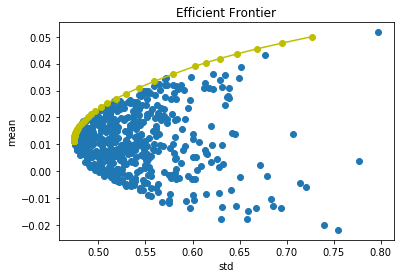

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd
#from zipline.utils.factory import load_bars_from_yahoo
import zipline


# These return series can be used to create a wide range of portfolios, which all have different 
# returns and risks (standard deviation).

# Seed the generator (start number, multiply by large number, mod of product)
np.random.seed(123)

# Turn off progress printing 
# Part of cvxopt
solvers.options['show_progress'] = False

# Return a sample (or samples) from the “standard normal” distribution.
n_assets = 4
n_obs = 1000
return_vec = np.random.randn(n_assets, n_obs)
print(return_vec)

# .T is for Transpose
# alpha is (0.0 transparent through 1.0 opaque)
#plt.plot(return_vec.T, alpha=0.4);
#plt.xlabel('time')
#plt.ylabel('returns')





# Generate random weights that sum to 1
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)



# Evaluate how many of these random portfolios would perform 
# Calculating mean returns and volatility (using SD here)
def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''
    
    # asmatrix Parameter: input data, output data type
    # mean of returns, axis = 1 = column
    p = np.asmatrix(np.mean(returns, axis=1))
    
    # shape returns tuple (n,m), so 0 is number of rows 
    w = np.asmatrix(rand_weights(returns.shape[0]))
    
    # cov: Estimate a covariance matrix, given data and weights
    C = np.asmatrix(np.cov(returns))
    
    # mu = expected return
    # (p = N * 1 column vector)
    # p.T = transpose of p = transpose of matrix with mean returns = 1 * N row vector 
    # w = weight vector of portfolio = N*1 weight column
    # p.T mulitpplied by w = scalar result 
    # IMPORTANT: PYTHON HAS REVERSED DEFINITION OF ROWS AND COLUMNS
    # ACCURATE NUMPY VERSION OF THE PREVIOUS EQUATION WOULD BE R = W * P.T
    
    mu = w * p.T
    
    # C is covariance of returns = N * N MATRIX =
    # NOTE: if use std(array(ret_vec).T*w) we would get a slightly different ’bullet’. NO COVARIANCE 
    # In the covariance matrix, the values of the diagonal represent the simple variances of each asset 
    # while the off-diagonals are the variances between the assets. 
    # By using ordinary std() we effectively only regard the diagonal and miss the rest.
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma




# Generate the mean returns and volatility for 500 random portfolios
# np.column_stack stacks 1-D arrays as columns into a 2-D array.

n_portfolios = 500
means, stds = np.column_stack([ 
    random_portfolio(return_vec) 
    for i in range(n_portfolios)
    # if big range, use xrange in PYTHON 2
    # if need to iterate list many times, use range 
])

# Form a characteristic parabolic shape called the ‘Markowitz bullet‘ with the boundaries being called 
# the ‘efficient frontier‘, where we have the lowest variance for a given expected.
#'o' is circle marker
#plt.plot(stds, means, 'o', markersize=5)
#plt.xlabel('std')
#plt.ylabel('mean')
#plt.title('Mean and standard deviation of returns of randomly generated portfolios')



def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    
    # The mus vector produces a series of expected return values in a non-linear and more appropriate way.
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    # np.eye --> Return a 2-D array with ones on the diagonal and zeros elsewhere.
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1)) # create a matrix with all zeros of size (n*1)
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x']
                  for mu in mus]
    
    # CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    
    # POLYFIT --> CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    # Least squares polynomial fit --> fit a polynomial with degree deg to points (x,y)
    # Returns a vector of coefficients p that minimises the squared error.
    m1 = np.polyfit(returns, risks, 2) 
    x1 = np.sqrt(m1[2] / m1[0])
    
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks



def plot_optimal_portfolio(return_vec):
    # Yellow is the optimal portfolios for each of the desired returns (i.e. the mus). 
    weights, returns, risks = optimal_portfolio(return_vec)
    plt.plot(stds, means, 'o')
    plt.ylabel('mean')
    plt.xlabel('std')
    plt.plot(risks, returns, 'y-o')
    plt.title('Efficient Frontier')
    
    #In addition, we get the one optimal portfolio returned:
    print(weights)
    
plot_optimal_portfolio(return_vec)

